In [1]:
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from collections import defaultdict
import json
from time import time

from reconstruct import get_SIFT_keypoints, get_X
from utils import read, compute_F, is_inside
from stereo import Stereo

# Stereo reconstruction using multiple images

In [2]:
images_number = [i for i in range(21)]
n_images = len(images_number)

In [3]:
images, P, silhouettes = zip(*[read(number) for number in images_number])

In [4]:
P = np.array(P)
silhouettes = np.array(silhouettes)

In [5]:
F = np.zeros((n_images, n_images, 3, 3))

In [6]:
for i in range(n_images):
    for j in range(i+1, n_images):
        f = compute_F(P[i], P[j])
        F[i,j] = f
        F[j,i] = f

In [7]:
n_keypoints = 40

In [8]:
kps = get_SIFT_keypoints(images[0], silhouettes[0], n_keypoints)

In [9]:
KP = np.zeros((n_images, n_keypoints, 3))

In [10]:
for i, (image, silhouette) in enumerate(zip(images, silhouettes)):
    KP[i] = get_SIFT_keypoints(image, silhouette, n_keypoints_min=n_keypoints)[:n_keypoints]

In [11]:
stereo = Stereo(silhouettes.shape[2], silhouettes.shape[1])

You can reconstruct 3D-points with the following cell, or load results bellow

In [ ]:
X_candidates = defaultdict(list)

ngh_threshold = 4

for i in tqdm(range(n_images)):
    for ik, x1 in enumerate(KP[i]):
        for j in range(n_images):
            if j != i and np.abs(j-i) <= ngh_threshold:
                x2 = stereo.find_x2(x1, F[i,j], images[i], images[j], kernel_size=[20,20])
                if (x2 is not None) and is_inside(x2, silhouettes[j]):
                    X_candidates[f"{i}_{ik}"].append(get_X(P[i], P[j], x1, x2))
                    
for k, v in X_candidates.items():
    X_candidates[k] = np.array(v)

In [ ]:
filename = f'X_candidates_{time()}.json'

In [ ]:
'''
x = defaultdict(list)
for k, v in X_candidates.items():
    x[k] = v.tolist()

with open(filename, 'w') as f:
    json.dump(x, f, indent=4)
'''

Load saved results

In [12]:
with open('X_candidates.json') as f:
    X_candidates = json.load(f)
for k, v in X_candidates.items():
    X_candidates[k] = np.array(v)

In [13]:
distances = []
for candidates in X_candidates.values():
    if len(candidates) >= 2:
        pd = pairwise_distances(candidates)
        for i in range(len(pd)):
            for j in range(i+1, len(pd)):
                distances.append(pd[i,j])
distances = np.array(distances)

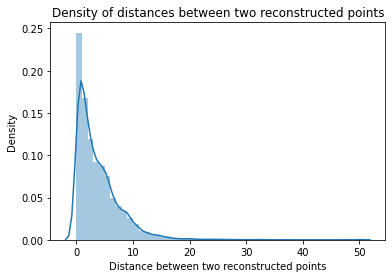

In [14]:
sns.distplot(distances.clip(0,50))
plt.xlabel("Distance between two reconstructed points")
plt.ylabel("Density")
plt.title("Density of distances between two reconstructed points")
plt.savefig("distances_density.png")
plt.show()

In [15]:
def select_X(candidates, th=5):
    pd = pairwise_distances(candidates)
    pd[pd > th] = th
    pd[pd == 0] = th
    if not (pd < th).any():
        return None
    
    return candidates[np.argmin(pd.mean(axis=1))]

In [16]:
X_list = []

for candidates in X_candidates.values():
    if len(candidates) > 2:
        X = select_X(candidates, th=3)
        if X is not None:
            X_list.append(X)
    
X_list = np.array(X_list)

# These are the results BEFORE removing outliers (please see vizualisation notebook)

In [18]:
#%matplotlib inline 
%matplotlib widget
fig = plt.figure()
ax = Axes3D(fig)

X_list = np.array(X_list)
ax.scatter(X_list[:,0], X_list[:,1], X_list[:,2])
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …